In [1]:
## new classification model
import os
import glob
import shutil
import numpy as np
import pandas as pd
from time import time
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from tensorflow.keras import optimizers
import tensorflow.keras.models as models
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import vgg16, vgg19, resnet, inception_v3
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

np.random.seed(123)
%matplotlib inline

In [2]:
def fetch_preprocess_data(data_dir = '/Users/jacksimonson/Springboard_Work/data/',
                          img_dim = (150, 150)):
    start = time()
    print('Fetching data...')

    files = glob.glob('{}training-image/*'.format(data_dir))
    benign_train = np.array([fn for fn in files if 'benign' in fn.lower()])
    malignant_train = np.array([fn for fn in files if 'malignant' in fn.lower()])
    print(f'benign training images: {len(benign_train)}\nmalignant training images: {len(malignant_train)}')
    
    files = glob.glob('{}test-image/*'.format(data_dir))
    benign_test = np.array([fn for fn in files if 'benign' in fn.lower()])
    malignant_test = np.array([fn for fn in files if 'malignant' in fn.lower()])
    print(f'benign test images: {len(benign_test)}\nmalignant test images: {len(malignant_test)}')
    
    print('Benign datasets:', benign_train.shape, benign_test.shape)
    print('Malignant datasets:', malignant_train.shape, malignant_test.shape)
    
    print('Moving data into sub-directories if necessary...')
    train_dir = '{}training_image_data'.format(data_dir)
    test_dir = '{}test_image_data'.format(data_dir)

    train_files = np.concatenate([benign_train, malignant_train])
    test_files = np.concatenate([benign_test, malignant_test])

    if os.path.isdir(train_dir):
        if len(os.listdir(train_dir)):
            print('    Training data already in correct directory')
        else:
            for fn in train_files:
                shutil.copy(fn, train_dir)
            print('    Training data moved')
    else:
        os.mkdir(train_dir)
        for fn in train_files:
                shutil.copy(fn, train_dir)
        print('    Training data moved')

    if os.path.isdir(test_dir):
        if len(os.listdir(test_dir)):
            print('    Test data already in correct directory')
        else:
            for fn in test_files:
                shutil.copy(fn, test_dir)
            print('    Test data moved')
    else:
        os.mkdir(test_dir)
        for fn in test_files:
                shutil.copy(fn, test_dir)
        print('    Test data moved')
    
    
    print('Transfering images to arrays of dimension {}...'.format(img_dim))
    train_files = glob.glob('{}/*'.format(train_dir))
    train_imgs = [img_to_array(load_img(img, target_size=img_dim)) for img in train_files]
    train_imgs = np.array(train_imgs)
    train_labels = [fn.split('/')[-1].split('_')[-1].replace('.png','').lower().strip() for fn in train_files]

    print('Train dataset shape:', train_imgs.shape)
    
    train_imgs_scaled = train_imgs.astype('float32')
    train_imgs_scaled /= 255

    print(f'Example train image shape: {train_imgs[0].shape}')
    
    input_shape = (img_dim[0], img_dim[1], 3)
    le = LabelEncoder()
    le.fit(train_labels)
    train_labels_enc = le.transform(train_labels)
    
    end = time()
    elapsed = end - start
    print('Data processing time is %f seconds.' % elapsed)
    
    return train_imgs, train_imgs_scaled, train_labels_enc, input_shape


In [3]:
# process data
train_imgs, train_imgs_scaled, train_labels_enc, input_shape = fetch_preprocess_data(data_dir = '/Users/jacksimonson/Springboard_Work/data/',
                                                                                     img_dim = (250, 250))

Fetching data...
benign training images: 1040
malignant training images: 1113
benign test images: 307
malignant test images: 264
Benign datasets: (1040,) (307,)
Malignant datasets: (1113,) (264,)
Moving data into sub-directories if necessary...
    Training data already in correct directory
    Test data already in correct directory
Transfering images to arrays of dimension (250, 250)...
Train dataset shape: (2153, 250, 250, 3)
Example train image shape: (250, 250, 3)
Example train image
<PIL.Image.Image image mode=RGB size=250x250 at 0x7FFCE03D70D0>
Data processing time is 356.163608 seconds.


Example train image


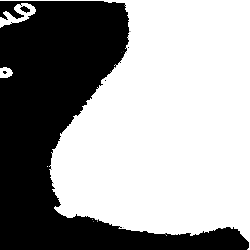

In [4]:
print(f'Example train image')
array_to_img(train_imgs[0])

### Vanilla CNN

In [5]:
def vanilla_cnn(batch_size = 30, num_classes = 2, epochs = 30, train_steps = 10, val_steps = 5,
                validation_split = 0.2, loss='binary_crossentropy', 
                metrics=['accuracy'], optimizer = optimizers.RMSprop(lr = 1e-4),
                train_batch_size = 30, val_batch_size = 20, augment = False,
                train_imgs_scaled = None, train_labels_enc = None, input_shape = None,
                train_imgs = None, model_path = '/Users/jacksimonson/Springboard_Work'):
    
    start = time()
    
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))


    model.compile(loss = loss,
                  optimizer=optimizer,
                  metrics=metrics)

    print(model.summary())
    
    if augment:
        train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                           width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                           horizontal_flip=True, fill_mode='nearest', validation_split = validation_split)

        train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=train_batch_size)
        val_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=val_batch_size)
        
        history = model.fit(train_generator, steps_per_epoch=train_steps, epochs=epochs,
                            validation_data=val_generator, validation_steps=val_steps, 
                            verbose=1)
    else:
        history = model.fit(x=train_imgs_scaled, y=train_labels_enc,
                            validation_split = validation_split,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    if augment:
        t = f.suptitle('Basic CNN with Augmentation', fontsize=12)
    else:
        t = f.suptitle('Basic CNN', fontsize=12)
    f.subplots_adjust(top=0.85, wspace=0.3)

    epoch_list = list(range(1,epochs + 1))
    ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
    ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xticks(np.arange(0, epochs + 1, 5))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    l1 = ax1.legend(loc="best")

    ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
    ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
    ax2.set_xticks(np.arange(0, epochs + 1, 5))
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    l2 = ax2.legend(loc="best")
    
    if augment:
        model_file_path = f'{model_path}/vanilla_cnn_model_with_augmentation.h5'
        model.save(model_file_path)
    else:
        model_file_path = f'{model_path}/vanilla_cnn_model.h5'
        model.save(model_file_path)
    
    end = time()
    elapsed = (end - start)/60
    if augment:
        print('Vanilla CNN with augmentation train time is %f minutes.' % elapsed)
    else:
        print('Vanilla CNN train time is %f minutes.' % elapsed)
    
    return model, history, f, (ax1, ax2), model_file_path

### Vanilla CNN

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 248, 248, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 124, 124, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 64)      9280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 59, 59, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 29, 29, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 27, 128)       1

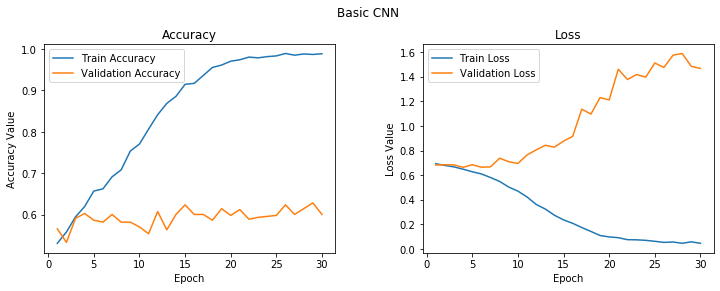

In [6]:
vanilla_model, vanilla_history, vanilla_f, (vanilla_ax1, vanilla_ax2), vanilla_model_file_path = vanilla_cnn(train_imgs_scaled = train_imgs_scaled,
                                                                                                             train_labels_enc = train_labels_enc,
                                                                                                             input_shape = input_shape,
                                                                                                             train_imgs = train_imgs)

### Vanilla CNN with Augmentation

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 248, 248, 16)      448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 124, 124, 16)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 122, 122, 64)      9280      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 59, 59, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 29, 29, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 27, 27, 128)      

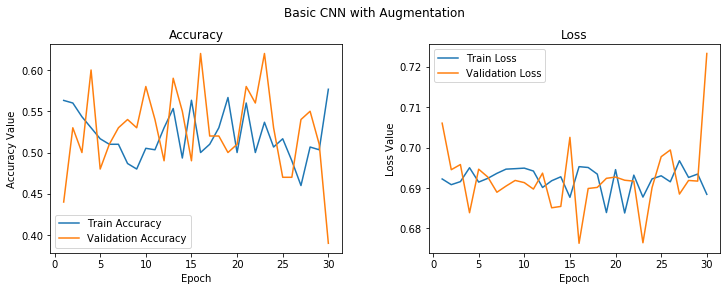

In [7]:
vanilla_model_augment, vanilla_history_augment, vanilla_f_augment, (vanilla_ax1_augment, vanilla_ax2_augment), vanilla_model_augment_file_path = vanilla_cnn(train_imgs_scaled = train_imgs_scaled,
                                                                                                                                                             train_labels_enc = train_labels_enc,
                                                                                                                                                             input_shape = input_shape,
                                                                                                                                                             train_imgs = train_imgs,
                                                                                                                                                             augment = True)

### Transfer Learning

In [8]:
# function to fit and train classifier
def run_transfer_classification(in_model = None, model_name = None, epochs = 25, train_steps = 10,
                                val_steps = 5, train_layers = [],
                                metrics=['accuracy'], validation_split = 0.2, train_batch_size = 30,
                                val_batch_size = 20, loss='binary_crossentropy', augment = False,
                                optimizer = optimizers.RMSprop(lr=1e-5),
                                model_path = '/Users/jacksimonson/Springboard_Work',
                                train_imgs_scaled = None, train_labels_enc = None,
                                input_imgs = None):
    
    start = time()
    
    if in_model is None:
        raise Exception('Please specify a model')

    output = in_model.layers[-1].output
    output = keras.layers.Flatten()(output)
    _model = Model(in_model.input, output)
    _model.trainable = True

    set_trainable = False
    for layer in _model.layers:
        if layer.name in ['block5_conv1', 'block4_conv1']:
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False

    layers = [(layer, layer.name, layer.trainable) for layer in _model.layers]
    print(pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']))

    input_shape = _model.output_shape[1]

    model = Sequential()
    model.add(_model)
    model.add(Dense(512, activation='relu', input_dim=input_shape))
    model.add(Dropout(0.3))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.RMSprop(lr=2e-5),
                  metrics=['accuracy'])

    print(model.summary())
    
    if augment:
        train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                           width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                           horizontal_flip=True, fill_mode='nearest',
                                           validation_split = validation_split)

        train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=train_batch_size)
        val_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=val_batch_size)
    
        history = model.fit(train_generator, steps_per_epoch=train_steps, epochs=epochs,
                            validation_steps=val_steps, validation_data=val_generator,
                            verbose=1)
    else:
        history = model.fit(x=train_imgs_scaled, y=train_labels_enc,
                            validation_split = validation_split,
                            batch_size=train_batch_size,
                            epochs=epochs,
                            verbose=1)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if augment:
        t = f.suptitle('{} CNN with Augmentation'.format(model_name), fontsize=12)
    else:
        t = f.suptitle('{} CNN'.format(model_name), fontsize=12)

    f.subplots_adjust(top=0.85, wspace=0.3)

    epoch_list = list(range(1,epochs + 1))
    ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
    ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xticks(np.arange(0, epochs + 1, 5))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    l1 = ax1.legend(loc="best")

    ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
    ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
    ax2.set_xticks(np.arange(0, epochs + 1, 5))
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    l2 = ax2.legend(loc="best")

    if augment:
        model_file_path = f'{model_path}/{model_name}_transfer_with_augmentation_model.h5'
        model.save(model_file_path)
    else:
        model_file_path = f'{model_path}/{model_name}_transfer_model.h5'
        model.save(model_file_path)
    
    end = time()
    elapsed = (end - start)/60
    if augment:
        print(f'{model_name} with augmentation train time is %f minutes.' % elapsed)
    else:
        print(f'{model_name} train time is %f minutes.' % elapsed)
    
    return model, history, f, (ax1, ax2), model_file_path

#### Get Models

In [9]:
# get models
models = {}
vgg16_model = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
vgg19_model = vgg19.VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
resnet_model = resnet.ResNet101(include_top=False, weights='imagenet', input_shape=input_shape)
inception_model = inception_v3.InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)

models = {'VGG16': (vgg16_model, False), 'VGG16_augment': (vgg16_model, True),
          'VGG19': (vgg19_model, False), 'VGG19_augment': (vgg19_model, True),
          'ResNet': (resnet_model, False), 'ResNet_augment': (resnet_model, True),
          'Inception': (inception_model, False), 'Inception_augment': (inception_model, True)}

#### Run Transfer Learning

In [10]:
# run classifier

# optimizer = optimizers.AdamOptimizer(lr=learning_rate) #optimizers.RMSprop(lr=1e-4)
transfer_results = {}
for model_name, tup in models.items():
    train_layers = ['block5_conv1', 'block4_conv1']
    in_model, augment = tup
    out_model, history, f, (ax1, ax2), model_file_path = run_transfer_classification(in_model = in_model,
                                                                                     model_name = model_name,
                                                                                     train_imgs_scaled = train_imgs_scaled,
                                                                                     input_imgs = train_imgs,
                                                                                     train_layers = train_layers,
                                                                                     augment = augment)
    transfer_results[model_name] = (out_model, history, f, (ax1, ax2), model_file_path)

                                           Layer Type    Layer Name  \
0   <tensorflow.python.keras.engine.input_layer.In...       input_1   
1   <tensorflow.python.keras.layers.convolutional....  block1_conv1   
2   <tensorflow.python.keras.layers.convolutional....  block1_conv2   
3   <tensorflow.python.keras.layers.pooling.MaxPoo...   block1_pool   
4   <tensorflow.python.keras.layers.convolutional....  block2_conv1   
5   <tensorflow.python.keras.layers.convolutional....  block2_conv2   
6   <tensorflow.python.keras.layers.pooling.MaxPoo...   block2_pool   
7   <tensorflow.python.keras.layers.convolutional....  block3_conv1   
8   <tensorflow.python.keras.layers.convolutional....  block3_conv2   
9   <tensorflow.python.keras.layers.convolutional....  block3_conv3   
10  <tensorflow.python.keras.layers.pooling.MaxPoo...   block3_pool   
11  <tensorflow.python.keras.layers.convolutional....  block4_conv1   
12  <tensorflow.python.keras.layers.convolutional....  block4_conv2   
13  <t

ValueError: in user code:

    /Users/jacksimonson/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    /Users/jacksimonson/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/jacksimonson/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/jacksimonson/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/jacksimonson/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:541 train_step  **
        self.trainable_variables)
    /Users/jacksimonson/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1804 _minimize
        trainable_variables))
    /Users/jacksimonson/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:521 _aggregate_gradients
        filtered_grads_and_vars = _filter_grads(grads_and_vars)
    /Users/jacksimonson/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:1219 _filter_grads
        ([v.name for _, v in grads_and_vars],))

    ValueError: No gradients provided for any variable: ['block4_conv1/kernel:0', 'block4_conv1/bias:0', 'block4_conv2/kernel:0', 'block4_conv2/bias:0', 'block4_conv3/kernel:0', 'block4_conv3/bias:0', 'block5_conv1/kernel:0', 'block5_conv1/bias:0', 'block5_conv2/kernel:0', 'block5_conv2/bias:0', 'block5_conv3/kernel:0', 'block5_conv3/bias:0', 'dense_6/kernel:0', 'dense_6/bias:0', 'dense_7/kernel:0', 'dense_7/bias:0', 'dense_8/kernel:0', 'dense_8/bias:0'].


                                            Layer Type           Layer Name  \
0    <tensorflow.python.keras.engine.input_layer.In...              input_3   
1    <tensorflow.python.keras.layers.convolutional....            conv1_pad   
2    <tensorflow.python.keras.layers.convolutional....           conv1_conv   
3    <tensorflow.python.keras.layers.normalization_...             conv1_bn   
4    <tensorflow.python.keras.layers.core.Activatio...           conv1_relu   
..                                                 ...                  ...   
341  <tensorflow.python.keras.layers.convolutional....  conv5_block3_3_conv   
342  <tensorflow.python.keras.layers.normalization_...    conv5_block3_3_bn   
343  <tensorflow.python.keras.layers.merge.Add obje...     conv5_block3_add   
344  <tensorflow.python.keras.layers.core.Activatio...     conv5_block3_out   
345  <tensorflow.python.keras.layers.core.Flatten o...            flatten_3   

     Layer Trainable  
0              False  
1    

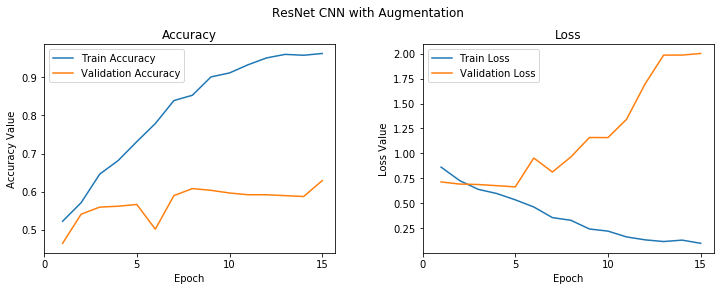

In [11]:
start = time()

in_model = resnet_model
model_name = 'ResNet'
epochs = 15
train_steps = 10
val_steps = 5
train_layers = ['block5_conv1', 'block4_conv1']
metrics=['accuracy']
validation_split = 0.2
train_batch_size = 30
val_batch_size = 20
loss='binary_crossentropy'
augment = False,
model_path = '/Users/jacksimonson/Springboard_Work'
output = in_model.layers[-1].output
output = keras.layers.Flatten()(output)
_model = Model(in_model.input, output)
_model.trainable = True

set_trainable = False
for layer in _model.layers:
    if layer.name in ['conv5_block2_1_conv']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

layers = [(layer, layer.name, layer.trainable) for layer in _model.layers]
print(pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']))

input_shape = _model.output_shape[1]

model = Sequential()
model.add(_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])

print(model.summary())
history = model.fit(x=train_imgs_scaled, y=train_labels_enc,
                    validation_split = validation_split,
                    batch_size=train_batch_size,
                    epochs=epochs,
                    verbose=1)

transfer_results[model_name] = (model, history)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
if augment:
    t = f.suptitle('{} CNN with Augmentation'.format(model_name), fontsize=12)
else:
    t = f.suptitle('{} CNN'.format(model_name), fontsize=12)

f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs + 1))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs + 1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs + 1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

if augment:
    model_file_path = f'{model_path}/{model_name}_transfer_with_augmentation_model.h5'
    model.save(model_file_path)
else:
    model_file_path = f'{model_path}/{model_name}_transfer_model.h5'
    model.save(model_file_path)
    
end = time()
elapsed = (end-start)/60

print(f'{model_name} train time is %f minutes.' % elapsed)

                                           Layer Type    Layer Name  \
0   <tensorflow.python.keras.engine.input_layer.In...       input_2   
1   <tensorflow.python.keras.layers.convolutional....  block1_conv1   
2   <tensorflow.python.keras.layers.convolutional....  block1_conv2   
3   <tensorflow.python.keras.layers.pooling.MaxPoo...   block1_pool   
4   <tensorflow.python.keras.layers.convolutional....  block2_conv1   
5   <tensorflow.python.keras.layers.convolutional....  block2_conv2   
6   <tensorflow.python.keras.layers.pooling.MaxPoo...   block2_pool   
7   <tensorflow.python.keras.layers.convolutional....  block3_conv1   
8   <tensorflow.python.keras.layers.convolutional....  block3_conv2   
9   <tensorflow.python.keras.layers.convolutional....  block3_conv3   
10  <tensorflow.python.keras.layers.convolutional....  block3_conv4   
11  <tensorflow.python.keras.layers.pooling.MaxPoo...   block3_pool   
12  <tensorflow.python.keras.layers.convolutional....  block4_conv1   
13  <t

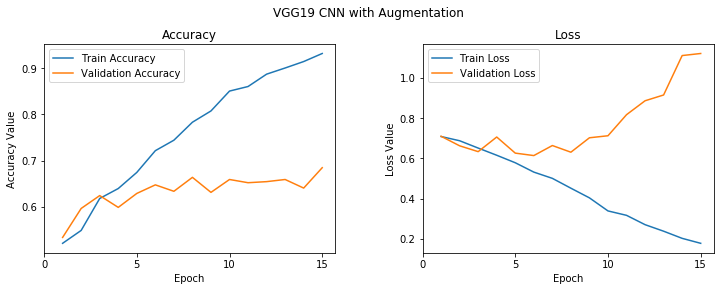

In [12]:
start = time()

in_model = vgg19_model
model_name = 'VGG19'
epochs = 15
train_steps = 10
val_steps = 5
train_layers = ['block5_conv1', 'block4_conv1']
metrics=['accuracy']
validation_split = 0.2
train_batch_size = 30
val_batch_size = 20
loss='binary_crossentropy'
augment = False,
model_path = '/Users/jacksimonson/Springboard_Work'
output = in_model.layers[-1].output
output = keras.layers.Flatten()(output)
_model = Model(in_model.input, output)
_model.trainable = True

set_trainable = False
for layer in _model.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

layers = [(layer, layer.name, layer.trainable) for layer in _model.layers]
print(pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']))

input_shape = _model.output_shape[1]

model = Sequential()
model.add(_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])

print(model.summary())
history = model.fit(x=train_imgs_scaled, y=train_labels_enc,
                    validation_split = validation_split,
                    batch_size=train_batch_size,
                    epochs=epochs,
                    verbose=1)

transfer_results[model_name] = (model, history)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
if augment:
    t = f.suptitle('{} CNN with Augmentation'.format(model_name), fontsize=12)
else:
    t = f.suptitle('{} CNN with Augmentation'.format(model_name), fontsize=12)

f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs + 1))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs + 1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs + 1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

if augment:
    model_file_path = f'{model_path}/{model_name}_transfer_with_augmentation_model.h5'
    model.save(model_file_path)
else:
    model_file_path = f'{model_path}/{model_name}_transfer_model.h5'
    model.save(model_file_path)
    
end = time()
elapsed = (end-start)/60

print(f'{model_name} train time is %f minutes.' % elapsed)

                                            Layer Type           Layer Name  \
0    <tensorflow.python.keras.engine.input_layer.In...              input_4   
1    <tensorflow.python.keras.layers.convolutional....             conv2d_8   
2    <tensorflow.python.keras.layers.normalization_...  batch_normalization   
3    <tensorflow.python.keras.layers.core.Activatio...           activation   
4    <tensorflow.python.keras.layers.convolutional....             conv2d_9   
..                                                 ...                  ...   
307  <tensorflow.python.keras.layers.merge.Concaten...             mixed9_1   
308  <tensorflow.python.keras.layers.merge.Concaten...        concatenate_1   
309  <tensorflow.python.keras.layers.core.Activatio...        activation_93   
310  <tensorflow.python.keras.layers.merge.Concaten...              mixed10   
311  <tensorflow.python.keras.layers.core.Flatten o...            flatten_5   

     Layer Trainable  
0              False  
1    

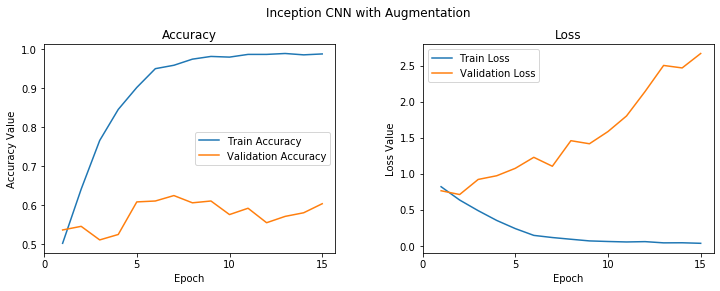

In [13]:
start = time()

in_model = inception_model
model_name = 'Inception'
epochs = 15
train_steps = 10
val_steps = 5
train_layers = ['block5_conv1', 'block4_conv1']
metrics=['accuracy']
validation_split = 0.2
train_batch_size = 30
val_batch_size = 20
loss='binary_crossentropy'
augment = False,
model_path = '/Users/jacksimonson/Springboard_Work'
output = in_model.layers[-1].output
output = keras.layers.Flatten()(output)
_model = Model(in_model.input, output)
_model.trainable = True


set_trainable = False
for layer in _model.layers:
    if layer.name in ['conv2d_83']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

layers = [(layer, layer.name, layer.trainable) for layer in _model.layers]
print(pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']))

input_shape = _model.output_shape[1]

model = Sequential()
model.add(_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])

print(model.summary())
history = model.fit(x=train_imgs_scaled, y=train_labels_enc,
                    validation_split = validation_split,
                    batch_size=train_batch_size,
                    epochs=epochs,
                    verbose=1)

transfer_results[model_name] = (model, history)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
if augment:
    t = f.suptitle('{} CNN with Augmentation'.format(model_name), fontsize=12)
else:
    t = f.suptitle('{} CNN'.format(model_name), fontsize=12)

f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs + 1))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs + 1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs + 1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

if augment:
    model_file_path = f'{model_path}/{model_name}_transfer_with_augmentation_model.h5'
    model.save(model_file_path)
else:
    model_file_path = f'{model_path}/{model_name}_transfer_model.h5'
    model.save(model_file_path)
    
    
end = time()
elapsed = (end-start)/60

print(f'{model_name} train time is %f minutes.' % elapsed)

In [14]:
transfer_results

{'ResNet': (<tensorflow.python.keras.engine.sequential.Sequential at 0x7ffcb0383750>,
  <tensorflow.python.keras.callbacks.History at 0x7ffc48f022d0>),
 'VGG19': (<tensorflow.python.keras.engine.sequential.Sequential at 0x7ffcb0375fd0>,
  <tensorflow.python.keras.callbacks.History at 0x7ffab0e65b50>),
 'Inception': (<tensorflow.python.keras.engine.sequential.Sequential at 0x7ffcd316a090>,
  <tensorflow.python.keras.callbacks.History at 0x7ffcd3675cd0>)}